# Deep Learning a PDE with PINNs (Worst of Options)

ToDo:
* Is there a way to set a minimum to the learning rate in the schedule?
* Go through dims up to 5D and save models/configs
* Clean-up everything
* In the conclusion/outlook, add the suggestion to price ATM options on all underlyings as additional outputs of the network, and fit them to the vanilla prices. Maybe this could help the network find good solutions, get out of local minima, and stabilitize/be more robust.


In [2]:
# Import relevant modules
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time as tm
import scipy.stats
import sklearn as sk
from sklearn.metrics import mean_squared_error
import tensorflow_probability as tfp
from platform import python_version

print("Python version: " + python_version())
print("TensorFlow version: " + tf.__version__)
print("TF-Keras version: " + tf.keras.__version__)
print("TF-Probability version: " + tfp.__version__)
print("NumPy version: " + np.__version__)
print("SciPy version: " + scipy.__version__)
print("SciKit version: " + sk.__version__)

Python version: 3.8.10
TensorFlow version: 2.11.0
TF-Keras version: 2.11.0
TF-Probability version: 0.19.0
NumPy version: 1.21.6
SciPy version: 1.7.3
SciKit version: 1.0.2


## 1) Parameters and helper functions

Set up parameters for the stochastic model (correlation, etc...), spot and vol values, the payoff (cap, floor, fixings, etc...), the PDE and its PINN solver. The correlation is a single number for simplicity of inputs, but can easily be replaced by a matrix. The number of assets is implied from the size of the spot vector. We also implement a number of helper functions including a payoff smoother for Monte-Carlo Greeks.

In [9]:
# Payoff and model parameters
dtype = 'float64'
tf.keras.backend.set_floatx(dtype)
# 2D
spot = np.asarray([100, 105], dtype=dtype)
vol = np.asarray([0.25, 0.35], dtype=dtype)
div = np.asarray([0.02, 0.01], dtype=dtype)
fixings = np.asarray([90, 95], dtype=dtype)  # Past value of the spot to measure performance
model_file = "model_2_assets.h5"
# 3D
# spot = np.asarray([100, 105, 102], dtype=dtype)
# vol = np.asarray([0.25, 0.35, 0.30], dtype=dtype)
# div = np.asarray([0.02, 0.01, 0.01], dtype=dtype)
# fixings = np.asarray([90, 95, 92], dtype=dtype)  # Past value of the spot to measure performance
# model_file = "model_3_assets.h5"
# 4D
# model_file = "model_4_assets.h5"
# 5D
# spot = np.asarray([100, 105, 102, 104, 103], dtype=dtype)
# vol = np.asarray([0.25, 0.35, 0.20, 0.40, 0.30], dtype=dtype)
# div = np.asarray([0.02, 0.01, 0.02, 0.03, 0.025], dtype=dtype)
# fixings = np.asarray([90, 95, 92, 97, 102], dtype=dtype)  # Past value of the spot to measure performance
# model_file = "model_5_assets.h5"

rate = 0.015
expiry = 2.5
floor = -10.0 / 100  # -1.5 / 100  # Flooring the worst performance
cap = 10.0 / 100  # Capping the best performance
notional = 10000.0  # 10 * 1000
num_assets = len(spot)
# Correlation matrix
correlation = 0.50
correl = np.ones((num_assets, num_assets), dtype=dtype) * correlation
for i in range(num_assets):
    correl[i, i] = 1.0
# Covariance matrix
cov = correl.copy()
for i in range(len(correl)):
    for j in range(len(correl)):
        cov[i, j] *= vol[i] * vol[j]

# Random generator seed
seed = 42

# If set to true, use saved model to compare against MC. We trained the models and saved them to files
# available online. The notebook loads them and compare against MC. The training is therefore not
# relevant. However, for simplicity and readability of the notebook, the training will happen if the
# corresponding cell is executed, but the execution can be skipped.
# Conversely, if use_saved_model is set to false, the comparison against MC will be based on the model
# trained here.
use_saved_model = True
root_save = ''
model_file = root_save + model_file

print("Number of assets: " + str(num_assets))
print("Correlation: " + str(correlation * 100) + "%")
if use_saved_model:
    print("Using pre-trained model at: " + model_file)

Number of assets: 2
Correlation: 50.0%
Using pre-trained model at: model_2_assets.h5


In [10]:
# Print vector
def print_vec(name, data):
    print(name + ": [", end=""),
    for i in range(len(data)):
        print("{:,.2f}".format(data[i]), end="")
        if i < len(data) - 1:
            print(", ", end="")
    print("]")

# Smoothing parameters (for the max function)
smooth_vol = 0.02
smooth_time = 10.0 / 365.0
smooth_stdev = smooth_vol * np.sqrt(smooth_time)
s2p = np.sqrt(2.0 * np.pi)
tf_N = tfp.distributions.Normal(0.0, 1.0)

# Tensorflow implementation of the payoff smoother ('tf_smooth_max')
def tf_approx_cdf(x):
    return 1.0 / (1.0 + tf.math.exp(-x / 0.5879))

# Tensorflow implementation of normal smoother
def tf_smooth_max(x, y):
    d1 = (x - y) / smooth_stdev
    # N1 = tf_N.cdf(d1)  # There was a problem with the one below for AD, but this one has a problem for float64
    N1 = tf_approx_cdf(d1)  # Older
    return (x - y) * N1 + 0.5 * smooth_stdev * tf.math.exp(-0.5 * tf.math.pow(d1, 2)) / s2p

## 2) PINN learning

In this section we implement the PDE solving using a PINN. The main idea is to consider the resolution of the PDE as an optimization problem, where the loss function receives two contributions: the PDE (i.e. an equation with a 0 right-hand side) and its boundaries (i.e. a collection of payoff evaluations at points in space and time that are relevant to the problem).

The network's inputs are 2d points in time and space, which we draw as 2 different types: the inner points and the boundaries. The network's output is the derivative's PV as a function of time and space. That is, the network gives us the PV not just for spot at $t=0$ but for any point in time and at any value of the spot between $t=0$ and maturity.

The loss function is a combination of a PDE contribution, targetting 0, and a boundary contribution where the target PV is assumed to be known. This is typically the case of the payoff at maturity, which can be augmented by "side boundaries" at earlier times but with extreme values of the spot (in a very similar fashion to the standard Finite Difference Method).

We start by defining the set of inner and boundary points. Then we evaluate the target values (PV) on these boundaries. As the target values of the PDE points is 0, that is sufficient to construct our dataset. Next we set up a network, define the loss function, and finally train the network.

In [11]:
# Time boundaries at 0 and expiry
tmin = tf.constant(0.0, dtype='float64')
tmax = tf.constant(expiry, dtype='float64')

# Spot boundaries defined as extreme percentiles of the distribution
N = scipy.stats.norm
fwdT = np.asarray(spot) * np.exp((rate - div) * expiry)
stdev = vol * np.sqrt(expiry)
conf = 0.9999  # Chosen percentile of the distributions
percentile = N.ppf(conf)
xmin = -0.5 * stdev * stdev - percentile * stdev
xmax = -0.5 * stdev * stdev + percentile * stdev
smin = fwdT * np.exp(xmin)
smax = fwdT * np.exp(xmax)

# Bounds in vector form (for input scaling)
lb = tf.concat([[tmin], xmin], axis=0)
ub = tf.concat([[tmax], xmax], axis=0)

print("Min time: {:,.2f}".format(tmin))
print("Max time: {:,.2f}".format(tmax))
print_vec("Spots", spot)
print_vec("Forwards", fwdT)
print_vec("Min spots", smin)
print_vec("Max spots", smax)
print_vec("Min red. spots", xmin)
print_vec("Max red. spots", xmax)

Min time: 0.00
Max time: 2.50
Spots: [100.00, 105.00]
Forwards: [98.76, 106.32]
Min spots: [21.00, 11.65]
Max spots: [397.27, 714.39]
Min red. spots: [-1.55, -2.21]
Max red. spots: [1.39, 1.90]


### a) Payoff and side boundaries

Specify the payoff at maturity and on the side boundaries.

In [12]:
# Payoff at maturity
def payoff(x):
    s = fwdT * tf.math.exp(x)
    perf = (s - fixings) / fixings
    perf = s / fixings - 1.0  # Weird Python bug? This line gives inaccuracies, but the above is accurate
    wperf = tf.math.reduce_min(perf, axis=1, keepdims=True)
    floored_rate = tf.math.maximum(wperf, floor)
    eff_rate = tf.math.minimum(floored_rate, cap)
    return notional * eff_rate

# At extreme low values of the spots, the worst performance is below the floor
def lw_boundary(t, x):
    n = x.shape[0]
    df_ = tf.math.exp(-rate * (tmax - t))
    return notional * df_ * tf.ones((n, 1), dtype='float64') * floor

# At extreme high values of the spots, the worst performance is above the cap
def up_boundary(t, x):
    n = x.shape[0]
    df_ = tf.math.exp(-rate * (tmax - t))
    return notional * df_ * tf.ones((n, 1), dtype='float64') * cap

### b) Build the dataset

Calculate the values of the payoff and side boundary points, then package the whole dataset into 2 buckets: the inner points and the boundary points (payoff and side). Note that the number of each type of points can be tuned, and in particular we may omit to include any side boundaries (to test numerically).

In [13]:
def build_dataset(num_final, nb, num_pde, init_rnd=False):
    if init_rnd:
        tf.random.set_seed(seed)

    # Draw payoff points
    t0 = tf.ones((num_final, 1), dtype='float64') * tmax
    x0 = tf.random.uniform((num_final, num_assets), xmin, xmax, dtype='float64')
    payoff_points = tf.concat([t0, x0], axis=1)
    payoff_values = payoff(x0)

    # Draw side boundaries points
    lw_tb = tf.random.uniform((nb, 1), tmin, tmax, dtype='float64')
    lw_xb = tf.ones((nb, num_assets), dtype='float64') * xmin
    up_tb = lw_tb  # We could also draw another set
    up_xb = tf.ones((nb, num_assets), dtype='float64') * xmax
    tb = tf.concat([lw_tb, up_tb], axis=0)
    xb = tf.concat([lw_xb, up_xb], axis=0)
    side_points = tf.concat([tb, xb], axis=1)
    lw_side_values = lw_boundary(lw_tb, lw_xb)
    up_side_values = up_boundary(up_tb, up_xb)
    side_values = tf.concat([lw_side_values, up_side_values], axis=0)

    # Pack boundary points together (payoff and side)
    if len(side_points) > 0:
        boundary_points_ = [payoff_points, side_points]
        boundary_values_ = [payoff_values, side_values]
    else:
        boundary_points_ = [payoff_points]
        boundary_values_ = [payoff_values]

    # Draw PDE points
    tpde = tf.random.uniform((num_pde, 1), tmin, tmax, dtype='float64')
    xpde = tf.random.uniform((num_pde, num_assets), xmin, xmax, dtype='float64')
    pde_points_ = tf.concat([tpde, xpde], axis=1)

    return pde_points_, boundary_points_, boundary_values_

### c) Model composition 

Now we set up the network architecture, leaving it essentially the same as what was chosen in our source material [J. Blechschmidt, O. G. Ernst](https://onlinelibrary.wiley.com/doi/full/10.1002/gamm.202100006). Right after the 2d input layer, a scaling layer is introduced to map the input data to the interval $(-1, 1)$. Then a number of hidden layers and a 1d output layer are added.

In [14]:
kinits = tf.keras.initializers
klayers = tf.keras.layers

def add_hidden_layer(model_, neurons_, activation_):
    init = kinits.glorot_normal

    model_.add(klayers.Dense(neurons_, activation=activation_, kernel_initializer=init,
                            use_bias=True, bias_initializer=kinits.Constant(0.1)))
    

# Set up the network architecture
def compose_model(hidden_layers_, num_neurons_):
    model_ = tf.keras.Sequential()

    # multi-d inputs
    model_.add(tf.keras.Input(1 + num_assets))

    # Scaling layer to map the inputs to (-1, 1)
    model_.add(klayers.Lambda(lambda x: 2.0 * (x - lb) / (ub - lb) - 1.0))

    # Hidden layers
    for hl in hidden_layers_:
        add_hidden_layer(model_, num_neurons_, hl)
        model_.add(klayers.Dropout(0.2))

    # 1d outputs
    model_.add(klayers.Dense(1))

    return model_

### d) PDE and loss function

The loss function is composed of 2 contributions coming from the inner PDE and the boundaries. The PDE can be resolved in the log-moneyness $X_i$ defined by $S_i(t) = F_i(0,t)e^{X_i(t)}$ for asset $i$:

\begin{equation}
\frac{\partial u}{\partial t} -\frac{1}{2}\sum_i\sigma_i^2 \frac{\partial u}{\partial X_i} + \frac{1}{2}\sum_{i,j}\sigma_i\rho_{i,j}\sigma_j \frac{\partial^2 u}{\partial X_i\partial X_j} - r u = 0.
\end{equation}

In the above $q_i$ is the dividend rate and $F_i(0,t) = S_i^0e^{(r-q_i)t}$ is the forward.

In [15]:
# Loss and gradient calculations
def calculate_pde(model_, pde_points_):
    with tf.GradientTape() as tape:
        # Split t and x to compute partial derivatives
        t, x = pde_points_[:, 0:1], pde_points_[:, 1:]
        tape.watch(x)  # We use this take for the 2nd order, so only need x
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t, x])
            point = tf.concat([t, x], axis=1)
            # Calculate function
            u = model_(point)

        # Compute space gradient
        u_x = tape2.gradient(u, x)

        # Compute time differential
        u_t = tape2.gradient(u, t)

    # Use batch jacobian as there is no dependency across points
    u_xx = tape.batch_jacobian(u_x, x)

    del tape2
    del tape

    # Calculate residual of the Black-Scholes PDE
    order1 = -0.5 * tf.reduce_sum(tf.math.pow(vol, 2) * u_x, axis=1, keepdims=True)
    order2 = 0.5 * tf.reduce_sum(tf.reduce_sum(cov * u_xx, axis=1, keepdims=True), axis=2, keepdims=True)

    return u_t + order1 + order2[:, 0] - rate * u

def calculate_loss(model_, pde_points_, boundary_points_, boundary_values_):
    # PDE contribution
    pde_r = calculate_pde(model_, pde_points_)
    pde_loss = tf.reduce_mean(tf.square(pde_r))

    # Boundary contributions
    u_pred = model_(boundary_points_[0])
    payoff_loss = tf.reduce_mean(tf.square(boundary_values_[0] - u_pred))
    u_pred = model_(boundary_points_[1])
    side_loss = tf.reduce_mean(tf.square(boundary_values_[1] - u_pred))

    # Total loss
    loss_ = pde_loss + payoff_loss + side_loss

    return loss_, pde_loss, payoff_loss, side_loss


def calculate_loss_grad(model_, pde_points_, boundary_points_, boundary_values_):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model_.trainable_variables)
        loss_, pde_loss, payoff_loss, side_loss = calculate_loss(model_, pde_points_, boundary_points_,
                                                                 boundary_values_)

    g = tape.gradient(loss_, model_.trainable_variables)
    del tape

    return loss_, g, pde_loss, payoff_loss, side_loss

# Test loss
# print('boundary points')
# pts = boundary_points[0]
# print(pts)
# pred = model(pts)
# ref = boundary_values[0]
# print(pred[0:5])
# print(ref[0:5])
# sq = tf.square(ref[0:5] - pred[0:5])
# ls = tf.reduce_mean(sq)
# print(sq)
# print(ls)
# print('pde_points')
# print(pde_points)
# r = calculate_pde(model, pde_points)
# print(r)

### e) Greeks by AD

As the inputs to the network are time and spot and its output is PV, we can obtain delta, theta and gamma by differentiating the network's output with respect to its inputs, using TensorFlow AD. TensorFlow's .jacobian() method is used to get the second derivatives on 2d points, but one could also consider splitting along the dimensions and apply .gradient() twice.

In [16]:
# Calculate network's differentials by AD
def eval_model(model_, points):
    tf_points_conv = tf.convert_to_tensor(points)

    # PV and Greeks
    t, x = tf_points_conv[:, 0:1], tf_points_conv[:, 1:]
    with tf.GradientTape() as tape1:
        tape1.watch(x)  # We use this take for the 2nd order, so only need x
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([t, x])
            tf_points = tf.concat([t, x], axis=1)
            pv = model_(tf_points)

        delta = tape2.gradient(pv, x)
        theta = tape2.gradient(pv, t)

    gamma = tape1.batch_jacobian(delta, x)

    # Recombine to go back to original coordinates
    fwd_ = spot * np.exp((rate - div) * t)
    spot_ = fwd_ * np.exp(x)
    delta = delta.numpy()
    theta = theta.numpy()
    gamma = gamma.numpy()
    theta -= np.sum((rate - div) * delta, axis=1, keepdims=True)

    # Recombine gamma explicitly
    for i in range(len(delta)):
        for j in range(num_assets):
            gamma[i, j, j] -= delta[i, j]
            for k in range(num_assets):
                gamma[i, j, k] = gamma[i, j, k] / (spot_[i, j] * spot_[i, k])

    delta = delta / spot_

    return pv.numpy(), delta, theta, gamma

## 3) Monte-Carlo as reference

In this section we implement the corresponding Monte-Carlo simulation for comparison purposes. We use AD to calculate the Greeks. We define as ladder of spot points for display purposes, and calculate the MC results on this ladder.

### a) Simulation

In [17]:
# Choose main and alternate direction to calculate/view Greeks
asset_idx = 0
cross_asset_idx = 1

# Direct MC simulation (non-tensor/non-AD)
def mc_simulation_pv(spot_, time_, gaussians):
    tf_spot = tf.convert_to_tensor(spot_, dtype='float64')
    tf_time = tf.convert_to_tensor(time_, dtype='float64')
    # tf_spot = tf.convert_to_tensor(spot_, dtype='float32')
    # tf_time = tf.convert_to_tensor(time_, dtype='float32')
  
    # Calculate deterministic forward
    fwd = tf_spot * tf.math.exp((rate - div) * tf_time)

    # Calculate final spot paths
    stdev = vol * tf.math.sqrt(tf_time)
    future_spot = fwd * tf.math.exp(-0.5 * stdev * stdev + stdev * gaussians)

    # Calculate discounted payoff
    df = tf.math.exp(-rate * tf_time)
    perf = future_spot / fixings - 1.0
    wperf = tf.reduce_min(perf, axis=1, keepdims=True)
    floored_rate = floor + tf_smooth_max(wperf, floor)
    eff_rate = cap - tf_smooth_max(-floored_rate, -cap)
    payoff = df * notional * eff_rate

    # Reduce
    pv = tf.reduce_mean(payoff, axis=0)

    return pv.numpy()[0]


def mc_simulation(spot_, time_, num_mc):
    rng = np.random.RandomState(seed)
    num_assets_ = spot_.shape[0]
    means = np.zeros(shape=(num_assets_))
    gaussians = rng.multivariate_normal(means, correl, size=num_mc)

    pv = mc_simulation_pv(spot_, time_, gaussians)

    # Delta and Gamma
    spot_bump = 0.01 * spot_
    spot_10 = spot_.copy()
    spot_10[asset_idx] += spot_bump[asset_idx]
    pv_10 = mc_simulation_pv(spot_10, time_, gaussians)
    spot_m10 = spot_.copy()
    spot_m10[asset_idx] -= spot_bump[asset_idx]
    pv_m10 = mc_simulation_pv(spot_m10, time_, gaussians)
    spot_01 = spot_.copy()
    spot_01[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_01 = mc_simulation_pv(spot_01, time_, gaussians)
    spot_0m1 = spot_.copy()
    spot_0m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_0m1 = mc_simulation_pv(spot_0m1, time_, gaussians)

    spot_11 = spot_.copy()
    spot_11[asset_idx] += spot_bump[asset_idx]
    spot_11[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_11 = mc_simulation_pv(spot_11, time_, gaussians)
    spot_1m1 = spot_.copy()
    spot_1m1[asset_idx] += spot_bump[asset_idx]
    spot_1m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_1m1 = mc_simulation_pv(spot_1m1, time_, gaussians)
    spot_m11 = spot_.copy()
    spot_m11[asset_idx] -= spot_bump[asset_idx]
    spot_m11[cross_asset_idx] += spot_bump[cross_asset_idx]
    pv_m11 = mc_simulation_pv(spot_m11, time_, gaussians)
    spot_m1m1 = spot_.copy()
    spot_m1m1[asset_idx] -= spot_bump[asset_idx]
    spot_m1m1[cross_asset_idx] -= spot_bump[cross_asset_idx]
    pv_m1m1 = mc_simulation_pv(spot_m1m1, time_, gaussians)

    delta_10 = (pv_10 - pv_m10) / (2.0 * spot_bump[asset_idx])
    delta_01 = (pv_01 - pv_0m1) / (2.0 * spot_bump[cross_asset_idx])
    delta = np.zeros(num_assets)
    delta[asset_idx] = delta_10
    delta[cross_asset_idx] = delta_01

    gamma_10 = (pv_10 + pv_m10 - 2.0 * pv) / np.power(spot_bump[asset_idx], 2.0)
    gamma_01 = (pv_01 + pv_0m1 - 2.0 * pv) / np.power(spot_bump[cross_asset_idx], 2.0)
    gamma_11 = (pv_11 - pv_1m1 - pv_m11 + pv_m1m1) / (4.0 * spot_bump[asset_idx] * spot_bump[cross_asset_idx])
    gamma = np.zeros(shape=(num_assets, num_assets))
    gamma[asset_idx, asset_idx] = gamma_10
    gamma[asset_idx, cross_asset_idx] = gamma[cross_asset_idx, asset_idx] = gamma_10
    gamma[cross_asset_idx, cross_asset_idx] = gamma_01
    

    # # Theta
    time_bump = 1.0 / 365.0
    pv_1d = mc_simulation_pv(spot_, time_ - time_bump, gaussians)
    theta = (pv_1d - pv) / time_bump

    return pv, delta, theta, gamma

# num_mc = 100
# spot_point = np.asarray([90.0, 95.0])
# pv, delta, theta, gamma = mc_simulation(spot_point, expiry, num_mc)
# print(pv)
# print(delta)
# print(theta)
# print(gamma)

### b) Comparison sample

We generate a ladder of spot points where all the assets are at their initial spot values except one for which we draw a ladder of values from low to high spots. 

In [37]:
# Choose asset direction, number of points and type of ladder
num_points = 50
# If set to true, the ladder is made by points spanning the training space jointly in each dimension.
# That is, the moneyness is the same in all dimensions for a given point.
# If set to false, the ladder is only in the chosen asset direction. All other dimensions are at the
# market spot.
use_joint_ladder = False

# Generate identical points at the initial spot value
x_space = np.zeros(shape=(num_points, num_assets), dtype='float64')

# Create a reduced spot ladder
if use_joint_ladder:
    x_space = np.linspace(xmin, xmax, num_points)
else:
    xmin_asset = xmin[asset_idx]
    xmax_asset = xmax[asset_idx]
    x_ladder = np.linspace(xmin_asset, xmax_asset, num_points)
    for i in range(num_points):
        x_space[i][asset_idx] = x_ladder[i]

# Calculate corresponding spot ladder
s_space = spot * np.exp(x_space)
s_ladder = s_space[:, asset_idx]

# print(xmin)
# print(xmax)
# print(x_space.shape)
# print(x_space)

### c) Calculate Monte-Carlo samples

Then we calculate PV, Delta, Theta and Gamma along that direction and compare with the Monte-Carlo method.

In [38]:
# Calculate by Monte-Carlo
num_mc = 100000

# Loop call
mc_start = tm.time()
mc_pv = np.ndarray((num_points, 1))
mc_delta = np.ndarray((num_points, num_assets))
mc_theta = np.ndarray((num_points, 1))
mc_gamma = np.ndarray((num_points, num_assets, num_assets))
for i in range(num_points):
    pv, delta, theta, gamma = mc_simulation(s_space[i], expiry, num_mc)
    mc_pv[i] = pv
    mc_delta[i] = delta
    mc_theta[i] = theta
    mc_gamma[i] = gamma

mc_time = tm.time() - mc_start
print('Runtime(Monte-Carlo): %.1f' % mc_time + 's')
# print("Spot space\n", s_space)
# print("PV\n", mc_pv)
# print("Delta\n", mc_delta)
# print("Theta\n", mc_theta)
# print("Gamma\n", mc_gamma)

Runtime(Monte-Carlo): 12.5s


## 4) Training

In this section we train the model to solve the PDE. We initialize the model first and define what a training step is. Then we train it.

### a) Initialize model and training

Specify number of layers, activation functions, and number of neurons per layer for the model topology. Then specify learning rate and decay for the optimizer. Initialize containers for later reference (history of loss, learning rate, etc...). This is where the model is initialized before any training starts.

A training step consists in optimizing the loss function over the whole set of points.

In [42]:
# Initialize model (one activation per hidden layer)
# Tested activations: tanh, softplus, softmax, relu, selu, elu, sigmoid
hidden_layers = ['softplus', 'softplus', 'softplus', 'softplus']  # 5D, 2D
# hidden_layers = ['softplus', 'softplus', 'softplus', 'softplus', 'softplus']  # 3D
num_neurons = 8  # 5D(16), 3D(8), 2D(8)

model = compose_model(hidden_layers, num_neurons)

# Learning rate scheduler
lr = 1e-1  # 5D(1e-1), 3D(1e-1), 2D(1e-1)
decay = 0.96  # 5D(0.99), 3D(), 2D(0.96)
steps = 100
staircase = True
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=lr, decay_steps=steps,
                                                             decay_rate=decay)

# Learning rate, decay and optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Optimizer fields
print("Optimizer settings")
optim_fields = optim.get_config()
for field in optim_fields:
    print(field, ":", optim_fields[field])

# Record loss and learning rate
loss_hist = []
lr_hist = []
use_best_model = True  # Periodically save weights and use best model
# Use rmse as indicator for 'best'. Not very realistic since using the MC reference which in practice will
# not be there. Set to false to more realistically use the loss instead. To use none of them, i.e. to use
# the last model at then end of the training, simply set use_best_model to false.
use_rmse_best_indicator = True
best_loss_to_date = np.finfo(dtype='float32').max

# Sample point sizes
num_final = 4 * 1000  # 5D(20 * 1000), 3D(6 * 1000), 2D(4 * 1000)
nb = 5 * 100  # 5D(2 * 1000), 3D(6 * 100), 2D(5 * 100)
num_pde = 4 * 1000  # 5D(20 * 1000), 3D(6 * 1000), 2D(4 * 1000)

# Generate sample points
tf.random.set_seed(seed)
np.random.seed(seed)
pde_points, boundary_points, boundary_values = build_dataset(num_final, nb, num_pde)

# Define training step
@tf.function
def train_step(pde_points_, boundary_points_, boundary_values_):
    # Compute current loss and gradient
    loss_, grad_, pde_loss, payoff_loss, side_loss = calculate_loss_grad(model, pde_points_, boundary_points_,
                                                                         boundary_values_)

    # Apply gradient descent
    optim.apply_gradients(zip(grad_, model.trainable_variables))

    return loss_, pde_loss, payoff_loss, side_loss

Optimizer settings
name : Adam
weight_decay : None
clipnorm : None
global_clipnorm : None
clipvalue : None
use_ema : False
ema_momentum : 0.99
ema_overwrite_frequency : None
jit_compile : False
is_legacy_optimizer : False
learning_rate : {'class_name': 'ExponentialDecay', 'config': {'initial_learning_rate': 0.1, 'decay_steps': 100, 'decay_rate': 0.96, 'staircase': False, 'name': None}}
beta_1 : 0.9
beta_2 : 0.999
epsilon : 1e-07
amsgrad : False


### b) Train the model

Here we launch the training. This step can be re-executed multiple times to increase convergence. At each execution the training continues where it left off. To re-initialize the model and re-start training from a raw model, re-execute the initialization step above.

[Warning] These models have a tendency to fall into local minima and get stuck there. As the algorithm is not totally reproducible at every run, we have observed that re-launching it from initialization above often helps it find a much better minimum.

In [48]:
# Training parameters
num_epochs = 5 * 1000
redraw_dataset = False  # Redraw dataset periodically

# Prepare comparison with MS
tpoint = np.asarray([0])
points = [np.concatenate([tpoint, x]) for x in x_space]

# Start the training
t0 = tm.time()
for i in range(num_epochs + 1):
    lr = optim.learning_rate.numpy()
    # lr = optim._decayed_lr(tf.float32).numpy()
    loss, pde_loss, payoff_loss, side_loss = train_step(pde_points, boundary_points, boundary_values)
    loss_hist.append(loss.numpy())
    lr_hist.append(lr)

    # Periodically display information such as loss, learning rate, rmse to reference, etc...
    if i % 100 == 0:
        md_pv = model(tf.convert_to_tensor(points))
        rmse_ = np.sqrt(sk.metrics.mean_squared_error(mc_pv, md_pv))
        print('Epoch {c:4,}/{h:,}: loss={a:,.0f}, '.format(h=num_epochs, c=i, a=loss), end="")
        # print('Epoch {c:4,}/{h:,}: loss={a:10.4e}, '.format(h=num_epochs, c=i, a=loss), end="")
        print('rmse(MC)={b:,.0f}'.format(b=rmse_), end="")
        print(', pde={b:,.0f}'.format(b=pde_loss), end="")
        print(', payoff={b:,.0f}'.format(b=payoff_loss), end="")
        print(', side={b:,.0f}'.format(b=side_loss), end="")
        print(', lr={b:.6f}'.format(b=lr))

    if redraw_dataset and i % 1000 == 0:
        pde_points, boundary_points, boundary_values = build_dataset(num_final, nb, num_pde)

    # Save model if best loss to date. Use rmse_ for best fit, but that's not very realistic.
    # Use the loss for a more realistic strategy.
    if use_best_model and i > 1000 & i % 100 == 0 and rmse_ < best_loss_to_date:
        model.save_weights("model_current_best.h5")
        best_loss_to_date = rmse_

print("")
print('Runtime: {:.3f} seconds'.format(tm.time() - t0))

Epoch    0/5,000: loss=1,148, rmse(MC)=14, pde=513, payoff=632, side=3, lr=0.000004
Epoch  100/5,000: loss=1,148, rmse(MC)=14, pde=513, payoff=632, side=3, lr=0.000004
Epoch  200/5,000: loss=1,147, rmse(MC)=14, pde=513, payoff=632, side=3, lr=0.000003
Epoch  300/5,000: loss=1,147, rmse(MC)=14, pde=513, payoff=632, side=3, lr=0.000003
Epoch  400/5,000: loss=1,147, rmse(MC)=14, pde=513, payoff=632, side=3, lr=0.000003
Epoch  500/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000003
Epoch  600/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000003
Epoch  700/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000003
Epoch  800/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000003
Epoch  900/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000003
Epoch 1,000/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr=0.000002
Epoch 1,100/5,000: loss=1,147, rmse(MC)=14, pde=512, payoff=632, side=3, lr

## 5) Comparison and plots

RMSE: 14.901349927941313


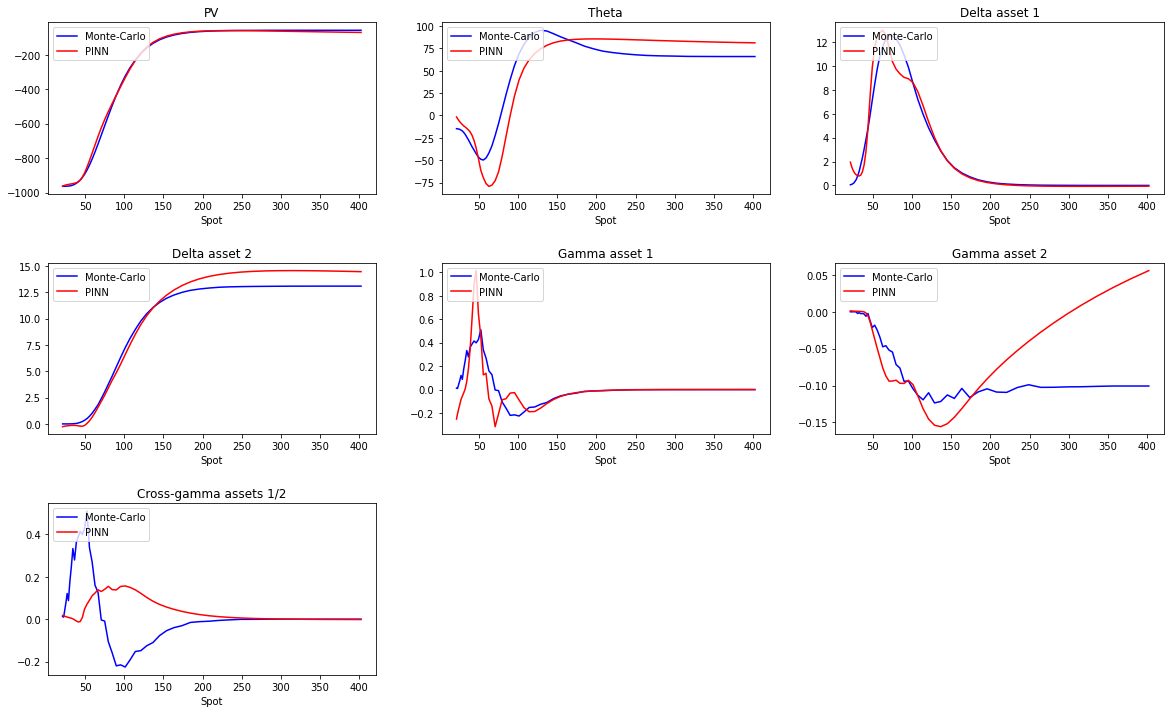

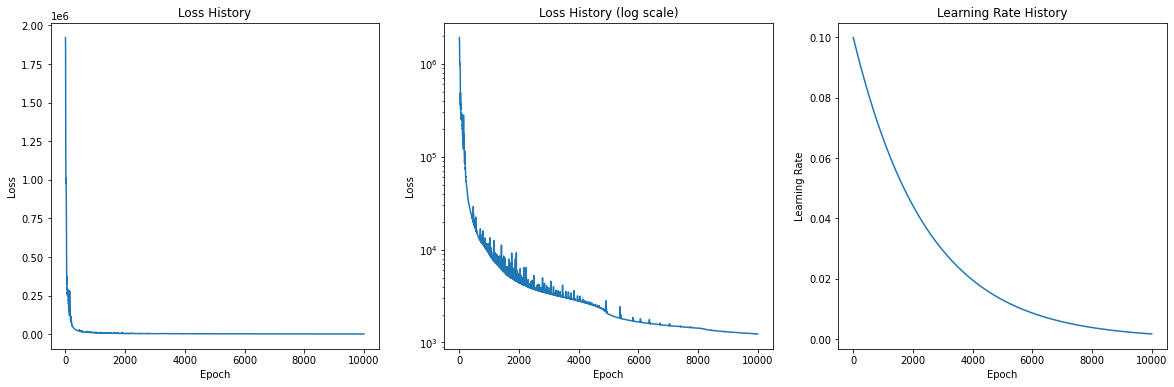

In [44]:
# Evaluate with the model
if use_best_model:
    model.load_weights("model_current_best.h5")

tpoint = np.asarray([0])
points = [np.concatenate([tpoint, x]) for x in x_space]
md_pv, md_delta, md_theta, md_gamma = eval_model(model, points)

# Calculate rmse
rmse_ = np.sqrt(sk.metrics.mean_squared_error(mc_pv, md_pv))
print("RMSE: " + str(rmse_))

# Plot
plt.figure(figsize=(20, 12))
plt.subplots_adjust(hspace=0.40)

plt.subplot(3, 3, 1)
plt.title("PV")
plt.xlabel('Spot')
plt.plot(s_ladder, mc_pv, color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_pv, color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 2)
plt.title("Theta")
plt.xlabel('Spot')
plt.plot(s_ladder, mc_theta, color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_theta, color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 3)
plt.title("Delta asset " + str(asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_delta[:, asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_delta[:, asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 4)
plt.title("Delta asset " + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_delta[:, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_delta[:, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 5)
plt.title("Gamma asset " + str(asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, asset_idx, asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, asset_idx, asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 6)
plt.title("Gamma asset " + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, cross_asset_idx, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, cross_asset_idx, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.subplot(3, 3, 7)
plt.title("Cross-gamma assets " + str(asset_idx + 1) + "/" + str(cross_asset_idx + 1))
plt.xlabel('Spot')
plt.plot(s_ladder, mc_gamma[:, asset_idx, cross_asset_idx], color='blue', label='Monte-Carlo')
plt.plot(s_ladder, md_gamma[:, asset_idx, cross_asset_idx], color='red', label='PINN')
plt.legend(loc='upper left')

plt.show()

# Plot loss history
plt.figure(figsize=(20, 6))
plt.subplots_adjust(hspace=0.40)
plt.subplot(1, 3, 1)
plt.title("Loss History")
plt.plot(range(len(loss_hist)), loss_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 3, 2)
plt.title("Loss History (log scale)")
plt.plot(range(len(loss_hist)), loss_hist)
plt.yscale("log")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1, 3, 3)
plt.title("Learning Rate History")
plt.plot(range(len(lr_hist)), lr_hist)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()